
## Why Persistence is Needed

For real applications, we need chat data that:
- Survives app restarts
- Can be loaded later
- Supports conversation history

This requires **persistent storage**.

---

## SQLite as a Solution

**SQLite** is a lightweight, file-based database.

### Benefits
- Data persists on disk
- No server setup required
- Easy to integrate
- Ideal for small to medium chat apps

### Typical Usage
- Store messages per `thread_id`
- Reload conversations on app restart
- Maintain long-term chat history

---
> But for prodction we don't use SQLite, we can go with PostgreSQL

In [9]:
## llm used 
from langchain_ollama import ChatOllama 

llm = ChatOllama(
    model='llama3.2',
    verbose=True,
    temperature=0.2
)

print(llm.invoke("Hey What are you doing?"))

content="I'm here to help answer your questions and provide information on a wide range of topics. I don't have personal activities or hobbies like humans do, but I'm always ready to assist with anything you'd like to discuss or learn about.\n\nIs there something specific on your mind that you'd like to talk about, or are you looking for recommendations or information on a particular topic? I'm all ears (or rather, all text)!" additional_kwargs={} response_metadata={'model': 'llama3.2', 'created_at': '2026-01-11T17:14:12.070312Z', 'done': True, 'done_reason': 'stop', 'total_duration': 14585636834, 'load_duration': 139860667, 'prompt_eval_count': 31, 'prompt_eval_duration': 10936417417, 'eval_count': 88, 'eval_duration': 3505612917, 'logprobs': None, 'model_name': 'llama3.2', 'model_provider': 'ollama'} id='lc_run--019bae0c-dde4-73e3-a37a-3305706fcc14-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 31, 'output_tokens': 88, 'total_tokens': 119}


In [10]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.sqlite import SqliteSaver
from typing import TypedDict, Annotated 
from langchain_core.prompts import PromptTemplate 
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages

import sqlite3

class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [11]:
def chat_llm(state: ChatState) -> ChatState:
    template = """
                You are a helpful conversational agent. Given the query and chathistoy in messages : {messages}.
                You need to prepare a short response. 
               """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['messages']
    )

    chain = prompt | llm 

    response = chain.invoke({'messages' : state['messages']})
    return {'messages' : response}

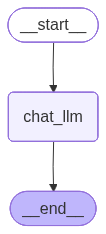

In [12]:
# create a database
from langgraph.checkpoint.sqlite import SqliteSaver

checkpointer = SqliteSaver(sqlite3.connect(database="checkpoint.db", check_same_thread=False))

# create the graph 
graph = StateGraph(ChatState)

# add a node 
graph.add_node('chat_llm', chat_llm)

# add edges 
graph.add_edge(START, 'chat_llm')
graph.add_edge('chat_llm', END)

# compile graph 
chatbot = graph.compile(checkpointer=checkpointer)

# display the graph 
from IPython.display import Image 
Image(chatbot.get_graph().draw_mermaid_png())

In [13]:
# settin gthe configuration andf thread_id 
config = {'configurable' : {'thread_id' : "thread-id-1"}}

input_state = {'messages' : [HumanMessage(content="Hello My name is Umesh.")]}

response = chatbot.stream(
    input_state,
    config=config,
    stream_mode="messages"
)

for chunk, metadata in response:
    print(chunk.content, end="", flush=True)

Here's a possible response:

"Nice to meet you, Umesh! It's great to have you here. How can I assist you today?"

In [14]:
def start_chat(thread_id):
    while True:
        # take input from user 
        config = {'configurable' : {'thread_id' : thread_id}}
        user_input = input("User Input : ")
        print(f"User Input : {user_input}")
        if user_input.strip().lower() in ['end', 'exit', 'bye']:
            print(f"Ending the Chat now!")
            break

        response = chatbot.stream(
            {'messages' : [HumanMessage(content=user_input)]},
            config=config,
            stream_mode="messages"
        )

        ai_message = ""

        print(f"AI response : ")
        for chunk, metadata in response:
            ai_message += chunk.content
            print(chunk.content, end="", flush=True)
        print("\n")
        print("-"*68)
    

#### Lets do Chat with thread_id = "thread-1"
Lets tallk about myself in this chat 

In [15]:
start_chat("thread-1")

User Input : Hello My name is Umesh
AI response : 
Nice to meet you, Umesh! It's great to have you here. How can I assist you today?

--------------------------------------------------------------------
User Input : end
Ending the Chat now!


#### Ltes do chat with 'thread_id' = 'thread-2'

This will be about my friend Alexa

In [16]:
start_chat("thread-2")

User Input : Hello My best friend in Alexa
AI response : 
That's a friendly greeting! Here's a possible response:

"Hey there, best friend in Alexa! It's great to hear from you. How can I help you today? Do you have any questions or just want to chat?"

--------------------------------------------------------------------
User Input : I said my best friend name is "Alexa"
AI response : 
It seems like you're having a conversation with Alexa, and you've mentioned that your best friend's name is "Alexa". That's quite interesting!

Here's a possible response from me:

"Ah, nice coincidence! I'm sure it's just a funny name, but I can see why you'd want to share it with someone who knows you well. What do you like about being named after Alexa?"

--------------------------------------------------------------------
User Input : end
Ending the Chat now!


---

> Now restart the notebook and don't execute previous two thread chats just run these

In [17]:
start_chat("thread-1")

User Input : What is my name?
AI response : 
Based on the chat history, I can see that Umesh has mentioned their name as "Umesh" in the first message.

Here's a possible short response:

"Hello Umesh! Nice to meet you too! Is there anything else I can help you with today?"

--------------------------------------------------------------------
User Input : end
Ending the Chat now!


In [18]:
start_chat("thread-2")

User Input : Who is my best friend?
AI response : 
It seems like you're having a conversation with Alexa, and you've mentioned that your best friend's name is "Alexa". That's quite interesting!

Here's a possible response from me:

"Ah, nice coincidence! I'm sure it's just a funny name, but I can see why you'd want to share it with someone who knows you well. What do you like about being named after Alexa?"

--------------------------------------------------------------------
User Input : end
Ending the Chat now!
